# Lab 11. Localization & Detection
by Domrachev Ivan, B20-Ro-01

In [ ]:
from keras.datasets import mnist
from nn_from_scratch.optimizers import GradientDescent
from nn_from_scratch.examples.simple_nn import NeuralNetwork
from nn_from_scratch.nodes import ReLU, SoftMaxLoss, Vectorization
from nn_from_scratch.neurons import Linear, Convolution
from nn_from_scratch.interfaces import Neuron
import tensorflow as tf
from tensorflow.keras import layers as t_layers


import numpy as np
from matplotlib import pyplot as plt

2023-11-14 00:26:53.456262: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-11-14 00:26:53.512749: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-11-14 00:26:53.513424: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-11-14 00:26:54.500490: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


# Part 1. Object classification

Finally, everything is ready to create a Convolutional Neural Network!

Conviniently, the framework from the simple Neural Network is suitable for the CNN as well, so let's utilize it:

In [ ]:
(train_X, train_y), (test_X, test_y) = mnist.load_data()
# CNN are slow...
train_X, train_y = train_X[:10000], train_y[:10000]
# Shuffle

p = np.random.permutation(len(train_X))
train_X, train_y = train_X[p], train_y[p]

n_input, n_output, batch_size, n_channels = 28**2, 10, 50, 1
assert train_X.shape[0] % batch_size == 0

train_X = train_X.reshape(train_X.shape[0] // batch_size, batch_size, n_channels, 28, 28)
train_y_ohe = np.zeros((len(train_y), n_output))
train_y_ohe[np.arange(len(train_y)), train_y] = 1
train_y_ohe = train_y_ohe.reshape((train_y.shape[0] // batch_size, batch_size, n_output))

In [ ]:
train_X.shape

(20, 50, 1, 28, 28)

The values preferably should belong to $[0; 1]$:

In [ ]:
train_X = train_X / 255
test_X = test_X / 255

In [ ]:
train_X.shape

(20, 50, 1, 28, 28)

Now, let's train!

In [ ]:
gds = GradientDescent(lr=1.0)
layers = [
    Convolution(
        (batch_size, n_channels, 28, 28), 
        kernel_size=3, 
        output_layers=4,
        use_bias=False
    ),
    ReLU((batch_size, 4, 26, 26)),
    Convolution(
        (batch_size, 4, 26, 26), 
        kernel_size=7,
        output_layers=2,
        use_bias=False
    ),
    ReLU((batch_size, 2, 20, 20)),
    Vectorization((batch_size, 2, 20, 20)),
    Linear((batch_size, 800), (batch_size, n_output))
]
loss_fn = SoftMaxLoss((batch_size, n_output))
network = NeuralNetwork(
    n_input=n_input, 
    n_output=n_output, 
    batch_size=batch_size, 
    optimizer=gds,
    layers=layers,  
    loss_fn=loss_fn
)
network.fit(train_X, train_y_ohe, n_epochs=5)

100%|██████████| 20/20 [00:06<00:00,  3.24it/s, loss=2.39]


Epoch 1, Loss: 2.385325974980187


100%|██████████| 20/20 [00:08<00:00,  2.48it/s, loss=2.32]


Epoch 2, Loss: 2.317311075130233


100%|██████████| 20/20 [00:07<00:00,  2.70it/s, loss=2.3] 


Epoch 3, Loss: 2.29986192882269


100%|██████████| 20/20 [00:07<00:00,  2.56it/s, loss=2.29]


Epoch 4, Loss: 2.29115831234554


100%|██████████| 20/20 [00:08<00:00,  2.45it/s, loss=2.29]

Epoch 5, Loss: 2.2863631005965455


array([2.2863631])

Great, loss is decreasing very slowly. Strange, let's check the predictions:

In [ ]:
print(network.predict(test_X[0]))
test_y[0]

[[142002.4    117895.266  145224.4    150341.86    40004.895   40305.4
  131635.92   166465.66    -1546.0656 103148.31  ]]


7

In [ ]:
def compute_accuracy(test_X: np.array, test_y: np.array, model) -> float:
    correct_predictions = 0
    total = 0

    for test_inputs, test_labels in zip(test_X, test_y):
        predicts = model.predict(test_inputs)
        pred_class = np.argmax(predicts, axis=1)

        correct_predictions += (pred_class == test_labels).sum()
        total += len(test_labels)

    return correct_predictions / total

In [ ]:
test_X_batches = test_X.reshape((test_X.shape[0] // batch_size, batch_size, n_channels, 28, 28))
test_y_batches = test_y.reshape((test_y.shape[0] // batch_size, batch_size,))

acc = compute_accuracy(test_X_batches, test_y_batches, network)
print(f"Accuracy: {acc}")

Accuracy: 0.4029


## Part 2. Object localization

In [ ]:
import d2l
import sys
sys.path.insert(0, '..')
import d2l
import pandas as pd
import os
import json
import numpy as np
from PIL import Image

In [ ]:
def load_dataset(dirname: str) -> tuple[np.ndarray, np.ndarray]:
    dataset = []
    annotations = []
    with open(dirname+'annotations.json') as fname:
        annotation_dict = json.load(fname)
    annotation_pd = pd.DataFrame.from_dict(annotation_dict, orient='index')

    for filepath in os.listdir(f'{dirname}/images'):
        img = np.array(Image.open(f'{dirname}/images/'+filepath).convert('RGB').resize((256, 256), Image.BILINEAR))
        bbox = annotation_pd.loc[annotation_pd['image']==filepath]['loc'][0]
        bbox = np.array([bbox[0], bbox[1], (bbox[2] - bbox[0]), (bbox[3] - bbox[1])])
        dataset.append(img)
        annotations.append(bbox)

    return np.array(dataset), np.array(annotations)

In [ ]:
train_pic, train_ann = load_dataset('dataset/train/')
train_pic.shape, train_ann.shape

((900, 256, 256, 3), (900, 4))

In [ ]:
val_pic, val_ann = load_dataset('dataset/val/')

In [ ]:
def plot_img(pics, ann, i=0):
    fig, ax = plt.subplots(1, 1)
    ax.imshow(pics[i])
    rect = Rectangle((ann[i][0:2] + 0.5)*255, (ann[i][2] + 0.5)*255, (ann[i][3] + 0.5)*255, lw=1, edgecolor='r',facecolor='none')
    ax.add_patch(rect)

    plt.show()

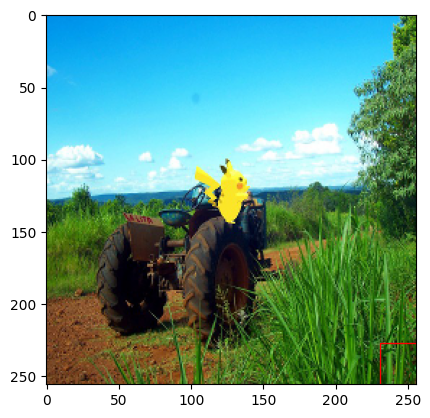

In [ ]:
plot_img(train_pic, train_ann, i=np.random.randint(len(train_pic)))

Now, let's create a model:

In [ ]:
batch_size = 10
n_channels = 3
n_output = 4
train_pic = train_pic.reshape(train_pic.shape[0] // batch_size, batch_size, n_channels, 256, 256)
train_ann = train_ann.reshape(train_ann.shape[0] // batch_size, batch_size, 4)

In [ ]:
train_pic = train_pic / 255

In [ ]:
from nn_from_scratch.nodes import NormalizedSoftMax

In [ ]:
gds = GradientDescent(lr=1e-5)
layers = [
    Convolution(
        (batch_size, n_channels, 256, 256), 
        kernel_size=3, 
        output_layers=4,
        use_bias=False
    ),
    ReLU((batch_size, 4, 254, 254)),
    Convolution(
        (batch_size, 4, 254, 254), 
        kernel_size=5,
        output_layers=2,
        use_bias=False
    ),
    ReLU((batch_size, 2, 250, 250)),
    Vectorization((batch_size, 2, 250, 250)),
    Linear((batch_size, 125000), (batch_size, n_output))
]
loss_fn = MSELoss((batch_size, n_output, ))
network = NeuralNetwork(
    n_input=28, 
    n_output=n_output, 
    batch_size=batch_size, 
    optimizer=gds,
    layers=layers,  
    loss_fn=loss_fn
)
network.fit(train_pic, train_ann, n_epochs=5)

  0%|          | 0/90 [00:00<?, ?it/s]

100%|██████████| 90/90 [02:51<00:00,  1.91s/it, loss=8.67e+3]


Epoch 1, Loss: 8674.407383725425


100%|██████████| 90/90 [02:54<00:00,  1.94s/it, loss=0.421]


Epoch 2, Loss: 0.42128618107652416


  6%|▌         | 5/90 [00:09<02:46,  1.96s/it, loss=0.436]


KeyboardInterrupt: 

In [ ]:
val_pic = val_pic.reshape(val_pic.shape[0] // batch_size, batch_size, n_channels, 256, 256)
val_ann = val_ann.reshape(val_ann.shape[0] // batch_size, batch_size, 4)

In [ ]:
pic_preds = network.predict(val_pic[0])
pic_preds[0]*256

array([150.78215 , 121.6687  , -49.687775, -11.213854], dtype=float32)

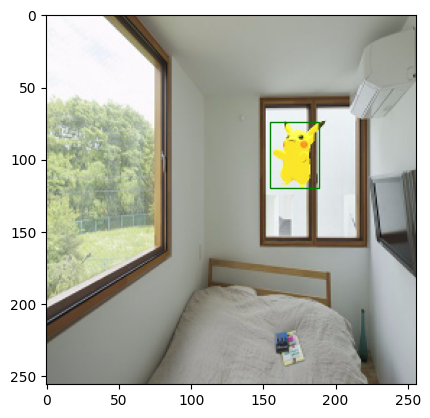

In [ ]:
fig, ax = plt.subplots(1, 1)
ax.imshow(val_pic[0, 0].reshape(256, 256, 3))
rect = Rectangle((val_ann[0, 0][0:2])*255, (val_ann[0, 0][2])*255, (val_ann[0,0][3])*255, lw=1, edgecolor='g',facecolor='none')
recp_pred = Rectangle((pic_preds[0][0:2])*255, (pic_preds[0][2])*255, (pic_preds[0][3])*255, lw=1, edgecolor='r',facecolor='none')
ax.add_patch(rect)

plt.show()

The main problem of this model is weights initialization: it either starts to train, or diverges).

I think that investigation into this problem might drastically improve the performance of the model.

If someone would run this code: run it several times, until it start to converge)

As one could see, the network is learning, however the results still could not be represented as a valid bbox prediction.